## Milne-Eddington Inversions of a HINODE dataset

Hi again! Now we are going to use the code we got familiar with yesterday to interpret some real-life data! We are going to look at the spectra of the real sun and from that we will infer orientation and magnitude of the magnetic field, and whatnot. This is really exciting. 

In [1]:
# Our good old packages for inversion, numerical manipulation and plotting...
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

# You might remember this one, this allows us to load fits files into numpy arrays
from astropy.io import fits

In [2]:
#Load the data
stokes = fits.open('/home/milic/scratch/sp_20150111_023539/test.fits')[0].data
stokes.shape

(384, 380, 4, 112)

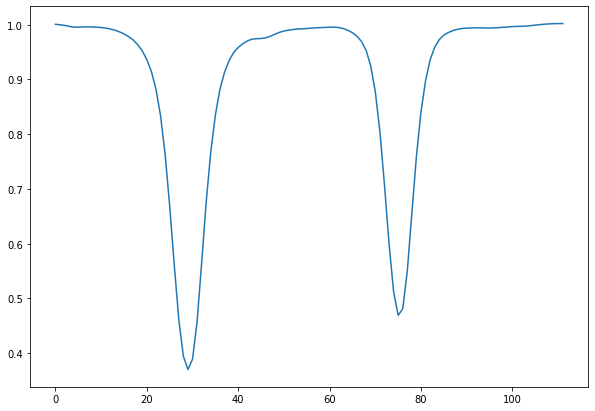

In [5]:
# I like first to calculte the mean spectrum and take a look at it:
mean_spectrum = np.mean(stokes,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(mean_spectrum[0])

#### Looks good, where should we expect our maximum of polarization to be?

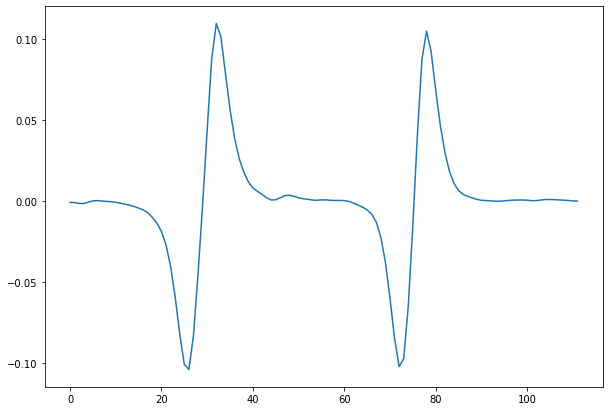

In [7]:
plt.figure(figsize=[10,7])
plt.plot(np.gradient(mean_spectrum[0]))

(20, 40)

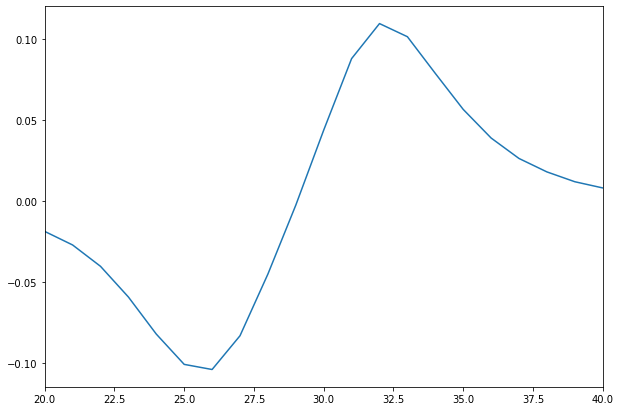

In [8]:
plt.figure(figsize=[10,7])
plt.plot(np.gradient(mean_spectrum[0]))
plt.xlim([20,40])

In [3]:
# Everything looks good (actually this is the same thing as the one we studied on the first day)
# We will normalize our data as before
# Mean over all the spatial points and the last 10 wavelengths
qs = np.mean(stokes[:,:,0,-10:])
stokes /= qs


In [13]:
# Let's also assign wavelengths.
# We are using the same equation as previously.
# Technically, if you decide to use a separate dataset, you should look up wavelength scaling in 
# the fits header (HINODE), or you should have it provded somewhere else. You can even do you own 
# wavelength calibration

ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215

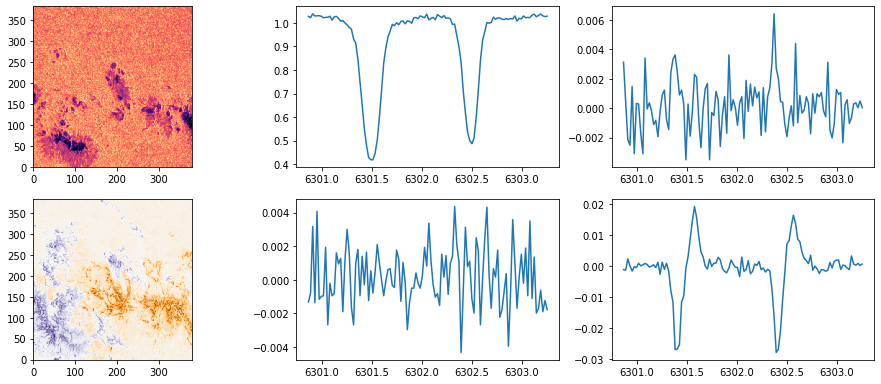

In [14]:
# Let's plot one example Stokes profile
i=100
j=200
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes[:,:,0,0],origin='Lower',cmap='magma')
plt.subplot(234)
plt.imshow(stokes[:,:,3,26],origin='Lower',cmap='PuOr')
plt.subplot(232)
plt.plot(ll,stokes[i,j,0])
plt.subplot(233)
plt.plot(ll,stokes[i,j,1])
plt.subplot(235)
plt.plot(ll,stokes[i,j,2])
plt.subplot(236)
plt.plot(ll,stokes[i,j,3])

### Ok what do you see here? Can someone comment on the shapes of the lines and the magnitudes of Stokes parameters? What do you think?

In [15]:
# Now we are going to try to invert that one spectra. 
# Inverting is fitting with M-E model.
# Let's try one line at the time. 

# What are the problems with inverting both lines simultaneously, can you discuss?
# We define wavelength regions. We will soon see what None refers to ;)

# We are inverting only the first one
regions = [[ll[:60], None]]

# These are the lines
lines   = [6301]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

In [16]:
# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 10. #noise is typicaly larger for I, because of systematics - Discuss!

In [17]:
# We are going to get used to deal with number of pixels, so here are some new variables for you :)
nx = 1
ny = 1
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])

# This creates nx x ny clones of model_guess
models_guess  = me.repeat_model(model_guess, nx, ny)

# What are we fitting, one Stokes profile, but remember the form it has to go in (nx x ny x 4 x n_lambda)
to_fit = stokes[i,j,:,:60].reshape(1,1,4,60)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 20, nIter=100, chi2_thres=1.0, verbose=False)


In [18]:
# Let's, for the sanity's sake, print out the quantities:
print ('Model parameters :', model_out)
print ('Chi-squared = ',chi2)

Model parameters : [[[ 2.75772497e+02  2.05077027e+00  1.26631205e-01 -3.41402638e-01
    5.55997666e-02  7.24715990e+00  2.53319282e-01  2.91785618e-01
    7.37060034e-01]]]
Chi-squared =  [[3.05578615]]


$\chi^2$ is around 1, which is a good sign, the best way to see the fit, is to plot!

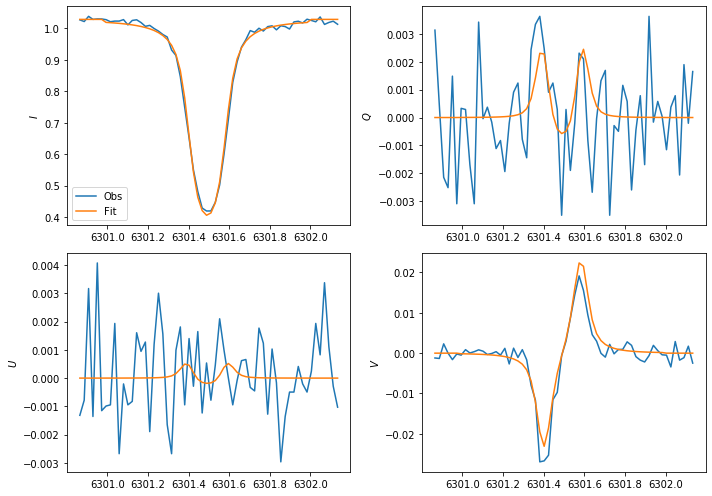

In [19]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll[:60],to_fit[0,0,0],label='Obs')
plt.plot(ll[:60],syn_out[0,0,0],label='Fit')
plt.ylabel("$I$")
plt.legend()
plt.subplot(222)
plt.plot(ll[:60],to_fit[0,0,1],label='Obs')
plt.plot(ll[:60],syn_out[0,0,1],label='Fit')
plt.ylabel("$Q$")
plt.subplot(223)
plt.plot(ll[:60],to_fit[0,0,2],label='Obs')
plt.plot(ll[:60],syn_out[0,0,2],label='Fit')
plt.ylabel("$U$")
plt.subplot(224)
plt.plot(ll[:60],to_fit[0,0,3],label='Obs')
plt.plot(ll[:60],syn_out[0,0,3],label='Fit')
plt.ylabel("$V$")
plt.tight_layout()

#### Looks good! 

Now, spend some time fitting individual pixels and looking what happens there!


After you are dont with that, we can move on and fit a part of field of view (or the whole one, if you have a nice pc)

In [20]:
# First part is to make use of the parallel capabilities of modern processors and do this with
# multiple threads
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


In [21]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 200 # and take this big chunk
ny = 200

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes[i:i+nx,j:j+ny,:,:60].reshape(nx,ny,4,60)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 20, nIter=50, chi2_thres=1.0, verbose=False)

CPU times: user 16min 46s, sys: 2.94 s, total: 16min 49s
Wall time: 2min 26s


In [22]:
print(model_out.shape)
print(chi2.shape)
#model_out = model_out.reshape(nx,ny,9)

(200, 200, 9)
(200, 200)


Well well well, look at that. Our parameters are also a cube now. And we even have a separate $\chi^2$ for each pixel! Looks great. Let's start by plotting $\chi^2$ map:

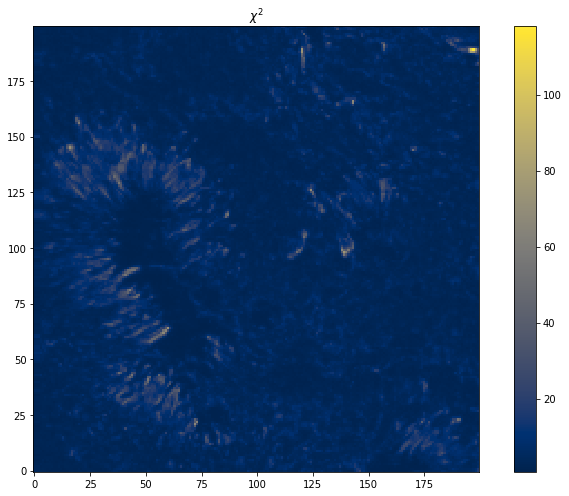

In [23]:
plt.figure(figsize=[10,7])
plt.imshow(chi2.T,cmap='cividis',origin='lower')
plt.title("$\chi^2$")
plt.colorbar()
plt.tight_layout()

Not bad, not bad. Seems like most of the pixels have $\chi^2$ of a few, while some number of pixels has somewhat larger values. 

Probably nothing to be worried about as we already know that our model is, striclty speaking, not correct! 

Velocity gradients, magnetic field gradients and other intricancies of radiative transfer lead to the departures. 

Now, let's plot some parameter maps:

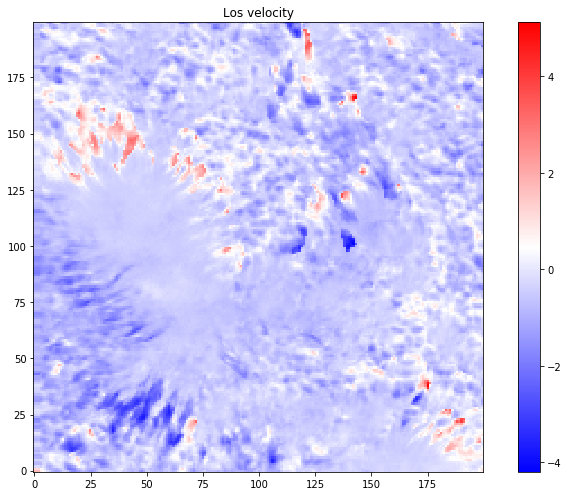

In [24]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower')
plt.title("Los velocity")
plt.colorbar()
plt.tight_layout()

Looks good! We see some structure on granular scale, and so on, let's look at the magnetic field strength:

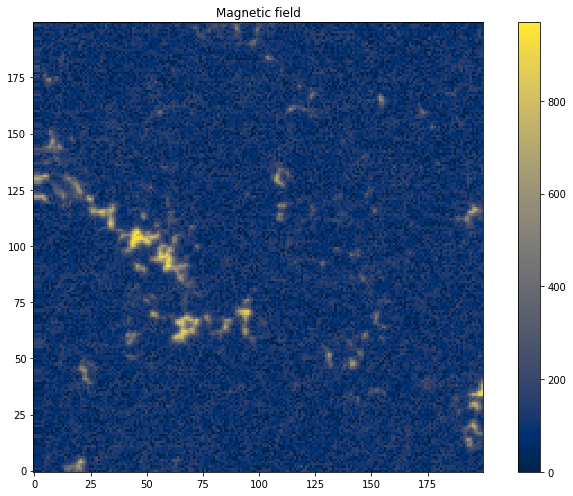

In [60]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower')
plt.title("Magnetic field")
plt.colorbar()
plt.tight_layout()

Interesting! We see a magnetic field structure that would perhaps resemble something as "network".
Even more interesting, the magnetic field structure corresponds to bad fits. Can you think why that is?

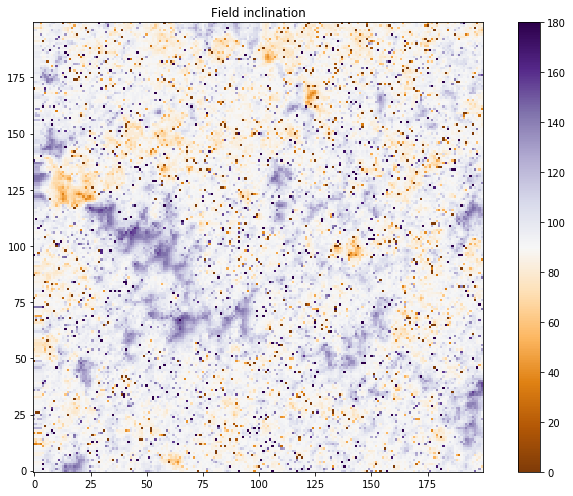

In [63]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()
plt.tight_layout()

Here we, for the first time, see an interesting effect - salt and pepper noise. Namely, at some points magnetic field is so low that we cannot really judge the inclination so well. Actually, there is a very good reason why in the most non-magnetic pixels, inclination is close to 90... Can you think of that? 

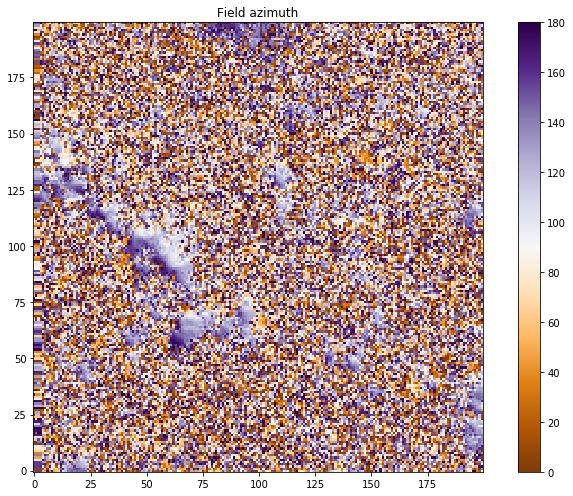

In [64]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,2].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field azimuth")
plt.colorbar()
plt.tight_layout()

This is now a complete mess! Excet for the network regions. Can you explain why? 

### Things to follow up with: 

1) Inversion with the other line 

2) Inversion with both the lines 

3) Further changing the weights 

4) Changing number of iterations, etc. 


In [65]:
# You might want to save these results for future use, to save a .fits file of the inverted parameters

# you can do something like this 
myhdu = fits.PrimaryHDU(model_out)
myhdu.writeto("inverted_models.fits",overwrite=True)